In [1]:
# %matplotlib widget

In [2]:
import numpy as np
from pathlib import Path
import pandas as pd
import flammkuchen as fl
import os

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import seaborn as sns
from itertools import product
from skimage.filters import threshold_otsu
from scipy.cluster.hierarchy import dendrogram, linkage
import cmocean as cmo

from scipy.stats import gaussian_kde

plt.style.use("figures.mplstyle")
cols = sns.color_palette()

In [3]:
fig_fold = Path(r"C:\Users\otprat\Documents\figures\luminance\manuscript_figures\fig3")

if not os.path.isdir(fig_fold):
    os.mkdir(fig_fold)

In [4]:
from luminance_analysis import traces_stim_from_path, PooledData
from luminance_analysis.utilities import deconv_resamp_norm_trace, reliability, \
    nanzscore, get_kernel, pearson_regressors, get_mn_and_error, train_test_split
from luminance_analysis.plotting import shade_plot, make_bar, get_yg_custom_cmap, add_offset_axes
from luminance_analysis.clustering import find_trunc_dendro_clusters

In [5]:
def regressors_from_stim(stim):
    """ Create the regressors for the regressor-based analysis.
    """
    dt = stim[1, 0]
    
    # Absolute luminance level-based regressors:
    reg_dict = dict()
    reg_dict["lum_true"] = stim[:, 1].copy()  # raw value
    reg_dict["lum_gamma1"] = stim[:, 1]**(1/3)  # gamma1
    reg_dict["lum_gamma2"] = stim[:, 1]**(0.1)  # gamma2
    reg_dict["lum_interm"] = stim[:, 1]**(0.05) - stim[:, 1]  # intermediate luminance

    # Integration-based:
    tau = 4  # tau for integrating regressor
    kernel = np.exp(-np.arange(0, 10, dt) / tau)
#     reg_dict["lum_integr"] = np.convolve(stim[:, 1], kernel / 100)[:stim.shape[0]]

    # Derivative-based:
    diff = np.insert(np.diff(stim[:, 1]**(1/3)), 0, 0)

    lum_on = diff.copy()
    lum_on[lum_on < 0] = 0
    reg_dict["trans_on"] = lum_on  # on transitions, proportional
    reg_dict["trans_on_abs"] = (lum_on > 0).astype(float)  # on transitions, absolute val

    lum_off = -diff.copy()
    lum_off[lum_off < 0] = 0
    reg_dict["trans_off"] = lum_off  # off transitions, proportional
    reg_dict["trans_off_abs"] = (lum_off > 0).astype(float)  # off transitions, absolute val

    reg_dict["trans_onoff"] = reg_dict["trans_on"] + reg_dict["trans_off"]  # on and off
    reg_dict["trans_onoff_abs"] = reg_dict["trans_on_abs"] + reg_dict["trans_off_abs"]  # on and off absolute
    
    return reg_dict

# Load data and create correlation matrices:

In [6]:
master_path = Path(r"\\FUNES2\legacy\experiments\E0032_luminance\neat_exps")

In [7]:
tau_6f = 5
ker_len = 30
delay = 3
n_clust = 5
normalization = "zscore"
protocol = "steps"

protocols = ["steps", "flashes"]
brain_regions_list = ["GC", "IO", "PC"]

data_dict = {"{}_{}".format(r, p):{} for p, r in product(["steps", "flashes"], ["GC", "IO"])}

for protocol, brain_region in product(["steps", "flashes"], ["GC", "IO"]):
    
    path = master_path / protocol / brain_region
    stim, traces, _ = traces_stim_from_path(path)

    # Mean traces, calculate reliability index :
    rel_idxs = reliability(traces)
    
    # Find threshold from reliability histogram...
    rel_thr = threshold_otsu(rel_idxs[~np.isnan(rel_idxs)])

    # ...and load again filtering with the threshold:
    _, traces, meanresps = traces_stim_from_path(path, resp_threshold=rel_thr, nanfraction_thr=1)
    
    
    # Fix problem with interpolated stimulus values between intermediate luminance levels:
    invalid_idxs = np.array([stim[:, 1] != n for n in [0, 1, 0.2, 0.05]]).all(0)  # find invalid indexes
    if sum(invalid_idxs) > 0:
        stim[np.argwhere(invalid_idxs), 1] = stim[np.argwhere(invalid_idxs)-1, 1]  # replace with following value
        
    # Create regressors:
    reg_dict = regressors_from_stim(stim)
    
    # Convolve them
    kernel = get_kernel(tau=tau_6f, ker_len=ker_len, delay=delay)
    reg_df = pd.DataFrame({k: nanzscore(np.convolve(reg_dict[k], kernel)[:stim.shape[0]]) for k in reg_dict.keys()})
    
    # Calculate regressions:
    coefs = pd.DataFrame(pearson_regressors(meanresps.T, reg_df.values).T, columns=reg_df.columns)
    
    # Cluster traces (needed for the sorted plots):
    linked = linkage(meanresps, "ward")    

    # make truncated tree to get clusters ids. 
    # Ugly but necessary to get the correct sequence of leaves:
    plt.figure(figsize=(0.1, 0.1))  
    dendro = dendrogram(linked, n_clust, truncate_mode ="lastp")
    plt.close()
    cluster_ids = dendro["leaves"]
    labels = find_trunc_dendro_clusters(linked, dendro)
    
    # Add everything to dictionary:
    key = "{}_{}".format(brain_region, protocol)
    data_dict[key]["raw_traces"] = traces
    data_dict[key]["mean_traces"] = meanresps
    data_dict[key]["stim"] = stim
    data_dict[key]["reg_df"] = reg_df
    data_dict[key]["coefs"] = coefs
    data_dict[key]["clust_labels"] = labels
    data_dict[key]["pooled"] = PooledData(path)
    
reg_keys = list(data_dict["GC_steps"]["reg_df"].columns)

[<luminance_analysis.FishData object at 0x000002D7B9872430>, <luminance_analysis.FishData object at 0x000002D7D0C4A280>, <luminance_analysis.FishData object at 0x000002D7D0C4A130>, <luminance_analysis.FishData object at 0x000002D7D0C4A730>, <luminance_analysis.FishData object at 0x000002D7D0C4A760>]


C:\tools\miniconda3\envs\prattest\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\tools\miniconda3\envs\prattest\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[<luminance_analysis.FishData object at 0x000002D7D0C4A670>, <luminance_analysis.FishData object at 0x000002D7D0C4A6D0>, <luminance_analysis.FishData object at 0x000002D7D0C4A2B0>, <luminance_analysis.FishData object at 0x000002D7D0C4A640>, <luminance_analysis.FishData object at 0x000002D7D0C4ACA0>]


C:\tools\miniconda3\envs\prattest\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\tools\miniconda3\envs\prattest\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[<luminance_analysis.FishData object at 0x000002D7D5497970>, <luminance_analysis.FishData object at 0x000002D7D0C4AD60>, <luminance_analysis.FishData object at 0x000002D7D0D62AF0>, <luminance_analysis.FishData object at 0x000002D7D0D62B20>, <luminance_analysis.FishData object at 0x000002D7D0D62B50>]
[<luminance_analysis.FishData object at 0x000002D7D0D62F40>, <luminance_analysis.FishData object at 0x000002D7D0D62CD0>, <luminance_analysis.FishData object at 0x000002D7D0D62E20>, <luminance_analysis.FishData object at 0x000002D7D0D62220>, <luminance_analysis.FishData object at 0x000002D7D0D62250>]
[<luminance_analysis.FishData object at 0x000002D7D0C4AAF0>, <luminance_analysis.FishData object at 0x000002D7D0D62250>, <luminance_analysis.FishData object at 0x000002D7D0D62190>, <luminance_analysis.FishData object at 0x000002D7D0D62BE0>, <luminance_analysis.FishData object at 0x000002D7D0D62F70>]
[<luminance_analysis.FishData object at 0x000002D7D0D62250>, <luminance_analysis.FishData object 

c:\users\otprat\repos\prat_et_al\luminance_analysis\__init__.py:448: RuntimeWarning: Mean of empty slice
  meanresps = np.nanmean(traces, 2)
c:\users\otprat\repos\prat_et_al\luminance_analysis\utilities.py:84: RuntimeWarning: Mean of empty slice
  reliability[i] = np.nanmean(corr)


[<luminance_analysis.FishData object at 0x000002D7D0D99A30>, <luminance_analysis.FishData object at 0x000002D7D0D99850>, <luminance_analysis.FishData object at 0x000002D7D0D99A90>, <luminance_analysis.FishData object at 0x000002D7D0D99B20>, <luminance_analysis.FishData object at 0x000002D7D0D99970>]


c:\users\otprat\repos\prat_et_al\luminance_analysis\utilities.py:84: RuntimeWarning: Mean of empty slice
  reliability[i] = np.nanmean(corr)
c:\users\otprat\repos\prat_et_al\luminance_analysis\utilities.py:8: RuntimeWarning: invalid value encountered in divide
  return (array - np.nanmean(array, axis=axis))/np.nanstd(array, axis=axis)
c:\users\otprat\repos\prat_et_al\luminance_analysis\utilities.py:162: RuntimeWarning: Mean of empty slice
  np.nanmean(Y, 0))
C:\tools\miniconda3\envs\prattest\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[<luminance_analysis.FishData object at 0x000002D7D0D99850>, <luminance_analysis.FishData object at 0x000002D7D0E1B1C0>, <luminance_analysis.FishData object at 0x000002D7D0E1B1F0>, <luminance_analysis.FishData object at 0x000002D7D0E8C6D0>, <luminance_analysis.FishData object at 0x000002D7D0E8C700>]
[<luminance_analysis.FishData object at 0x000002D7D0E8CF40>, <luminance_analysis.FishData object at 0x000002D7D0E8C670>, <luminance_analysis.FishData object at 0x000002D7D0E8C760>, <luminance_analysis.FishData object at 0x000002D7D0E8C4C0>, <luminance_analysis.FishData object at 0x000002D7D0E8C2B0>]


c:\users\otprat\repos\prat_et_al\luminance_analysis\utilities.py:84: RuntimeWarning: Mean of empty slice
  reliability[i] = np.nanmean(corr)


[<luminance_analysis.FishData object at 0x000002D7D0E8C4C0>, <luminance_analysis.FishData object at 0x000002D7D0E8C3D0>, <luminance_analysis.FishData object at 0x000002D7D0E8C370>, <luminance_analysis.FishData object at 0x000002D7D0E8C2E0>, <luminance_analysis.FishData object at 0x000002D7D0DDDD30>]


c:\users\otprat\repos\prat_et_al\luminance_analysis\utilities.py:84: RuntimeWarning: Mean of empty slice
  reliability[i] = np.nanmean(corr)
c:\users\otprat\repos\prat_et_al\luminance_analysis\utilities.py:8: RuntimeWarning: invalid value encountered in divide
  return (array - np.nanmean(array, axis=axis))/np.nanstd(array, axis=axis)
c:\users\otprat\repos\prat_et_al\luminance_analysis\utilities.py:162: RuntimeWarning: Mean of empty slice
  np.nanmean(Y, 0))
C:\tools\miniconda3\envs\prattest\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[<luminance_analysis.FishData object at 0x000002D7D0E98E20>, <luminance_analysis.FishData object at 0x000002D7D0E98DF0>, <luminance_analysis.FishData object at 0x000002D7D0E2B820>, <luminance_analysis.FishData object at 0x000002D7D1034700>, <luminance_analysis.FishData object at 0x000002D7D1034730>]


For the regressor plot, find best predicted trace from each regressor (considering only the steps protocol):

In [8]:
def plot_traces_regressors(data_dict, figure=None, frame=None,
                           regressors_list=["lum_true", "lum_interm", "trans_off", "trans_onoff"]):
    
    # Combine IO and GC steps regressors in a single matrix:
    io_and_gc_coefs = np.concatenate([data_dict[c + "_steps"]["coefs"].values for c in ["GC", "IO"]], axis=0)
    n_gc_steps = len(data_dict["GC_steps"]["coefs"])  # number of gc in the combined gc and io coefficients matrix

    # For each regressor, find best predicted cell:
    best_reg_idx = np.array([np.argmax(io_and_gc_coefs[:, c]) for c in range(io_and_gc_coefs.shape[1])])

    # For each regressor find the type of the best predicted cell:
    cell_type = np.array(["GC"]*io_and_gc_coefs.shape[1])
    cell_type[best_reg_idx > n_gc_steps] = "IO"

    # Now from best predicted cell index find index in the relative traces array:
    best_reg_idx_pertype = best_reg_idx.copy()
    best_reg_idx_pertype[best_reg_idx > n_gc_steps] -= n_gc_steps

    offset = 7
    barlength = 10  # scalebar in seconds

    if figure is None:
        figure = plt.figure(figsize=(7, 3))
    ax = add_offset_axes(figure, (0., 0.1, 1, 0.9), frame=frame)

    reg_keys = list(data_dict["GC_steps"]["reg_df"].columns)
    for n, reg in enumerate(regressors_list):
        i = reg_keys.index(reg)
        stim = data_dict["{}_steps".format(cell_type[i])]["stim"]
        reg_df = data_dict["{}_steps".format(cell_type[i])]["reg_df"]
        tracecol = sns.color_palette()[0] if cell_type[i] == "GC" else sns.color_palette()[1]
        trace = data_dict["{}_steps".format(cell_type[i])]["mean_traces"][best_reg_idx_pertype[i], :]
        coef_value = io_and_gc_coefs[best_reg_idx[i], i]
        
        reg_trace = reg_df[reg] - offset * n
        ax.fill_between(stim[:, 0], np.zeros(len(reg_trace)) + np.min(reg_trace), reg_trace
                        , facecolor=sns.color_palette()[7], edgecolor=None, alpha=0.5, zorder=100)
        ax.plot(stim[:, 0], nanzscore(trace) - offset * n, c=tracecol, zorder=100)
        ax.text(1, 2.7 - offset*n, "{} - {} (R: {:1.2})".format(reg, cell_type[i], coef_value), fontsize=7, color=tracecol)


    shade_plot(stim, shade_range=(0.8, 0.97))
    ax.set_xlim(stim[0, 0], stim[-1, 0])

    ax.set_yticks([])
    ax.set_ylim(None, 4)
    ax.spines["left"].set_visible(False)
    make_bar(ax, [stim[-1, 0] - barlength, stim[-1, 0]], 
             label="{} s".format(barlength))
    
    #return figure

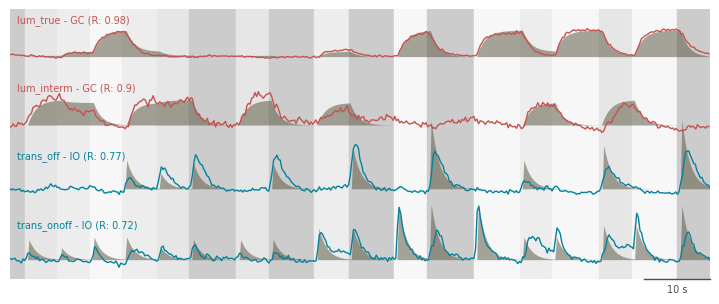

In [9]:
plot_traces_regressors(data_dict, plt.figure(figsize=(7, 3)), frame=(0, 0, 1, 1))

Supplementary figure for all regressors:

In [10]:
def reg_hist_figure(data_dict, figure=None, frame=None):
    if figure is None:
        figure = plt.figure(figsize=(2.5,2.5))    

    for i, c in enumerate(["GC", "IO"]):
        ax = add_offset_axes(figure, (0.1, 0.05 + 1-0.34*(i+1), 0.7, 0.23), frame=frame)
        coefs = data_dict[c + "_steps"]["coefs"].values

        best_regressors = np.nanargmax(np.abs(coefs), 1)
        percent = np.sum(best_regressors < 4) / len(best_regressors) * 100

        ax.hist(best_regressors, np.arange(0,11,1), density=True, stacked=True, color=cols[i])
        ax.axvline(4, c="k", linestyle="dashed")
        ax.set_yticks([])
        ax.set_xticks([])

        ax.text(9.8, plt.gca().get_ylim()[1]/2, c, fontsize=7, color=cols[i], fontweight="bold")
        ax.text(2, plt.gca().get_ylim()[1], "{:2.1f}%".format(percent), fontsize=7, color=cols[i])
        ax.text(7, plt.gca().get_ylim()[1], "{:2.1f}%".format(100 - percent), fontsize=7, color=cols[i])

    ax.set_xticks(np.arange(len(reg_keys))+0.5)
    ax.set_xticklabels(reg_keys, rotation=80)
    sns.despine(left=True)

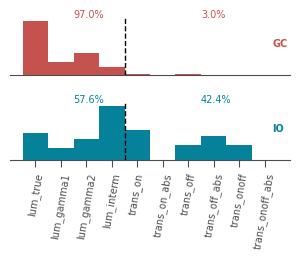

In [11]:
figure = plt.figure(figsize=(4,2.5)) 
reg_hist_figure(data_dict, figure=figure)

Scatterplot

In [12]:
def regr_scatter_plot(data_dict, figure=None, frame=None, size=5):

    if figure is None:
        figure = plt.figure(figsize=(3,3))
        
    lims=(-0.05,1.05)
    alpha=1
    alpha_kde=0.4
    n_lum_clust = 4  # number of luminance regressors in the regressor panel
    
    all_gc = pd.concat([data_dict["GC_" + s]["coefs"] for s in ["steps", "flashes"]], axis=0)
    all_io = pd.concat([data_dict["IO_" + s]["coefs"] for s in ["steps", "flashes"]], axis=0)

    ax_scatter = add_offset_axes(figure, (0.2, 0.2, 0.5, 0.5), frame=frame)
    dwn = all_gc.shape[0] // (all_io.shape[0]*2)  # Downsampling factor to show equal number of points
    x_gc = np.nanmax(np.abs(all_gc.values[::dwn, :n_lum_clust]), 1)
    y_gc = np.nanmax(np.abs(all_gc.values[::dwn, n_lum_clust:]), 1)
    ax_scatter.scatter(x_gc, y_gc, s=size, alpha=alpha, color=cols[0], label="GC")

    x_io = np.nanmax(np.abs(all_io.values[:, :n_lum_clust]), 1)
    y_io = np.nanmax(np.abs(all_io.values[:, n_lum_clust:]), 1)
    ax_scatter.scatter(x_io, y_io, s=size, alpha=alpha, color=cols[1], label="IO")
    ax_scatter.text(0.9, 0.9, "GC", color=cols[0], fontweight="bold", fontsize=7)
    ax_scatter.text(0.9, 0.8, "IO", color=cols[1], fontweight="bold", fontsize=7)

    ax_scatter.set_aspect('equal')
    ax_scatter.set_xlim(*lims)
    ax_scatter.set_ylim(*lims)
    ax_scatter.set_xticks(np.arange(0,1.1,0.2))
    ax_scatter.set_yticks(np.arange(0,1.1,0.2))
    ax_scatter.set_xlabel("Luminance corr. coef.")
    ax_scatter.set_ylabel("Transition corr. coef.")

    x_arr = np.arange(lims[0],lims[1], 0.01)
    
    ax_kde2 = add_offset_axes(figure, (0.2, 0.7, 0.5, 0.2), frame=frame)
    ax_kde2.axis("off")
    ax_kde2.fill_between(x_arr, np.zeros(x_arr.shape), gaussian_kde(x_gc)(x_arr), alpha=alpha_kde)
    ax_kde2.fill_between(x_arr, np.zeros(x_arr.shape), gaussian_kde(x_io)(x_arr), alpha=alpha_kde)
    
    ax_kde1 = add_offset_axes(figure, (0.7, 0.2, 0.2, 0.5), frame=frame)
    ax_kde1.axis("off")
    ax_kde1.fill_betweenx(x_arr, np.zeros(x_arr.shape), gaussian_kde(y_gc)(x_arr), alpha=alpha_kde)
    ax_kde1.fill_betweenx(x_arr, np.zeros(x_arr.shape), gaussian_kde(y_io)(x_arr), alpha=alpha_kde)

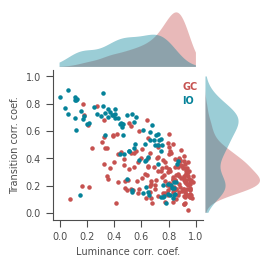

In [13]:
regr_scatter_plot(data_dict)

### Decoding of absolute luminance values

In [14]:
decoding_path = Path().resolve().parent/'decoding'

In [15]:
io_pred_data = fl.load(decoding_path / "abs_lum_decoding_results_IO_final.h5")
gc_pred_data = fl.load(decoding_path / "abs_lum_decoding_results_GCsubsampled_final.h5")

In [16]:
lum_levels = np.array([0.  , 0.05, 0.2 , 1.  ])

In [17]:
def plot_luminance_decoding(io_data, gc_data, figure=None, frame=None):

    if figure is None:
        figure = plt.figure(figsize=(10, 5))
             
    for i, (decoding, population) in enumerate(zip([gc_data, io_data],['GCs', 'IONs'])):    
        ax_scatter = add_offset_axes(figure, (0.1+0.4*i, 0.15, .3, .8), frame=frame)
        
        if i==0:
            all_iters = pd.concat(gc_data)
            sns.violinplot(x=all_iters['lum_true'], y=all_iters['lum_svm'], color=sns.color_palette()[i], ax=ax_scatter)
            plt.setp(ax_scatter.collections, alpha=.75, edgecolor=sns.color_palette()[i], facecolor='white')

#             for pc in violin_parts['bodies']:
#                 pc.set_facecolor('red')
#                 pc.set_edgecolor('black')

            
            plot_iter = 5
            sns.swarmplot(x=decoding[plot_iter].lum_true, y=decoding[plot_iter]["lum_svm"], s=1.7, ax=ax_scatter, color=sns.color_palette()[i])
            ax_scatter.set_ylabel('Predicted luminance')
        if i==1:
            sns.swarmplot(x=decoding.lum_true, y=decoding["lum_svm"], s=1.7, ax=ax_scatter, color=sns.color_palette()[i])
            ax_scatter.set_ylabel('')

        ax_scatter.hlines(lum_levels, np.arange(-0.4, 3.6, 1), np.arange(0.4, 3.5, 1), lw=1, color=(0.3, 0.3, 0.3), zorder=3)
        ax_scatter.set_xlabel('Actual luminance')
        ax_scatter.set_ylim([-.25,1.4])
        ax_scatter.set_title(population)


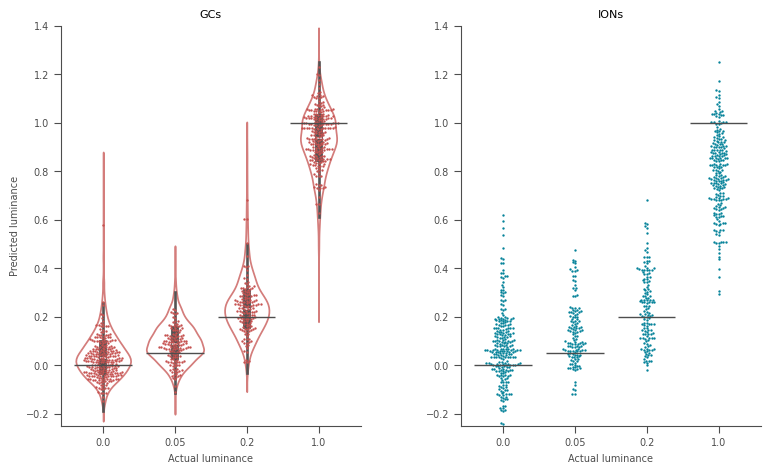

In [18]:
plot_luminance_decoding(io_pred_data, gc_pred_data)

### Decoding of transitions

In [19]:
io_trans_data = fl.load(decoding_path / "transition_results_IO_final.h5")
gc_trans_data = fl.load(decoding_path / "transition_results_GC_final.h5")
all_options = fl.load(decoding_path / "all_options.h5")

C:\tools\miniconda3\envs\prattest\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\tools\miniconda3\envs\prattest\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [20]:
from collections import namedtuple
from itertools import product, starmap

In [21]:
def named_product(**items):
    Product = namedtuple("Product", items.keys())
    return starmap(Product, product(*items.values()))

def confmat(pred_bins, pred_gt):
    """ Calculate the confusion matrix by averaging the probaility
    distribution of the decoded category for each appearence of that
    category (indexed by pred_gt)
    """
    pred_gt = pred_gt.astype(np.int32)
    n_bins = pred_bins.shape[1]
    confmat = np.zeros((n_bins, n_bins))
    n_avg = np.zeros(n_bins, dtype=np.uint16)
    for i in range(len(pred_gt)):
        confmat[pred_gt[i], :] += pred_bins[i, :]
        n_avg[pred_gt[i]] += 1
    return confmat/n_avg[:, None]

In [22]:
n_test = 2

option_it = list(named_product(**all_options))
copt = option_it[0]
io_confusion_mat = confmat(io_trans_data[0], np.tile(all_options["features"][copt.features], n_test))

In [23]:
confusion_mats_list = []

for i in range(len(gc_trans_data)):
    option_it = list(named_product(**all_options))

    copt = option_it[0]
    confusion_mats_list.append(confmat(gc_trans_data[i][0], np.tile(all_options["features"][copt.features], n_test)))
    
gc_confusion_mats = np.stack(confusion_mats_list)

In [24]:
def plot_confmat(confusion_mat):

    plt.figure()
    plt.imshow(confusion_mat, cmap=cmo.cm.tempo, origin='lower')
    plt.colorbar()
    plt.title("transition {} decoded from {} with a {} decoder".format(copt.features, copt.population, copt.decoder))
    plt.xlabel('Predicted transition')
    plt.ylabel('Actual transition')

In [25]:
transitions = [np.nan, -1,-.2,-.05, 0, .05, .2, 1]

In [26]:
def plot_transition_confmats(io_mat, gc_mats, figure=None, frame=None):

    if figure is None:
        figure = plt.figure(figsize=(10, 5))
             
    for i, (confmat, population) in enumerate(zip([gc_mats, io_mat],['GCs', 'IONs'])):    
        ax_confmat = add_offset_axes(figure, (0.1+0.4*i, 0.15, .3, .8), frame=frame)
        if i==0:
            ax_confmat.imshow(np.nanmean(confmat, 0), cmap=cmo.cm.tempo, origin='lower')
            ax_confmat.set_ylabel('Actual transition')
        else:
            im = ax_confmat.imshow(confmat, cmap=cmo.cm.tempo, origin='lower')
       
        ax_confmat.set_title(population)
        ax_confmat.set_xlabel('Predicted transition')
        ax_confmat.set_xticklabels(transitions)
        ax_confmat.set_yticklabels(transitions)
        
    axcolor = add_offset_axes(figure, (.825, 0.35, 0.015, 0.4), frame=frame)
    cbar=plt.colorbar(im, cax=axcolor, orientation='vertical', ticks=[0,.2,.4,.6,.8,1])
    cbar.set_label('Probability')

C:\Users\otprat\AppData\Local\Temp\ipykernel_17060\2697309366.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_confmat.set_xticklabels(transitions)
C:\Users\otprat\AppData\Local\Temp\ipykernel_17060\2697309366.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_confmat.set_yticklabels(transitions)


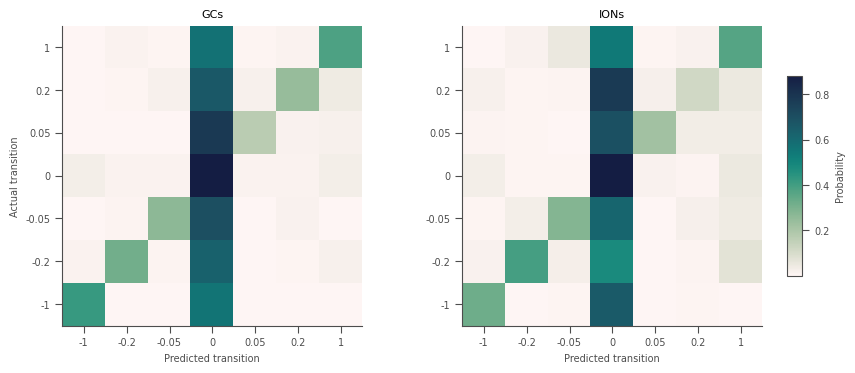

In [27]:
plot_transition_confmats(io_confusion_mat, gc_confusion_mats)

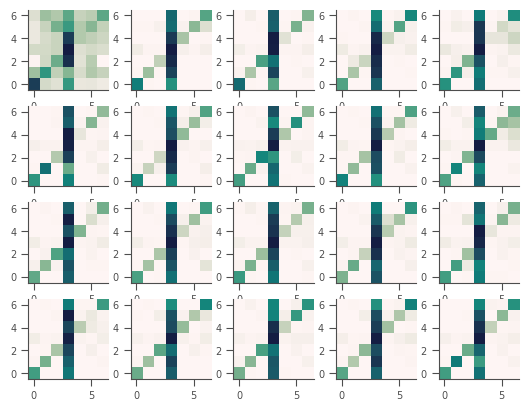

In [28]:
fig, axes = plt.subplots(4,5)
axes = axes.ravel()
    
for i in range(20):
    axes[i].imshow(gc_confusion_mats[i, :, :], cmap=cmo.cm.tempo, origin='lower')

# Assemble final figure

C:\tools\miniconda3\envs\prattest\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\tools\miniconda3\envs\prattest\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\otprat\AppData\Local\Temp\ipykernel_17060\2697309366.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_confmat.set_xticklabels(transitions)
C:\Users\otprat\AppData\Local\Temp\ipykernel_17060\2697309366.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_confmat.set_yticklabels(transitions)


Text(0.1, 0.275, 'E')

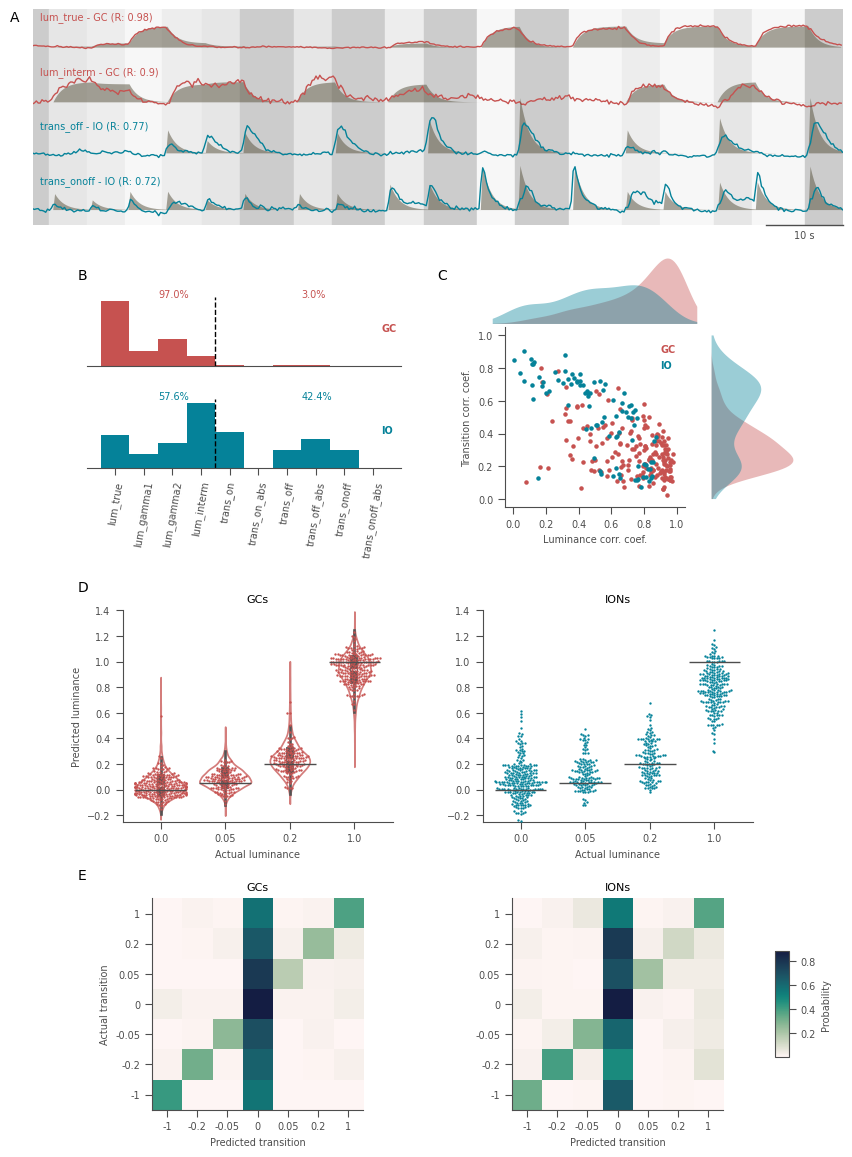

In [29]:
figure3 = plt.figure(figsize=(9,12))

# Regressors traces:
plot_traces_regressors(data_dict, figure=figure3, frame=(0.05, 0.8, .9, 0.2))
figure3.text(.025,.99, 'A')

# Regressors histogram:
reg_hist_figure(data_dict, figure=figure3, frame=(0.06, 0.525, 0.5, 0.25))
figure3.text(.1,.775, 'B')

# Regressors scatterplot:
regr_scatter_plot(data_dict, figure=figure3, frame=(0.45, 0.525, 0.5, 0.3))
figure3.text(.5,.775, 'C')

# Luminance value decoding
plot_luminance_decoding(io_pred_data, gc_pred_data, figure=figure3, frame=(0.05, 0.29, 1, 0.22))
figure3.text(.1,.515, 'D')

# Luminance transition decoding
plot_transition_confmats(io_confusion_mat, gc_confusion_mats, figure=figure3, frame=(0.05, 0.05, 1, .22))
figure3.text(.1,.275, 'E')

In [30]:
if fig_fold is not None:
    figure3.savefig(str(fig_fold / "comparison.pdf"))

C:\tools\miniconda3\envs\prattest\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 6.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.1, 0.35, 'D')

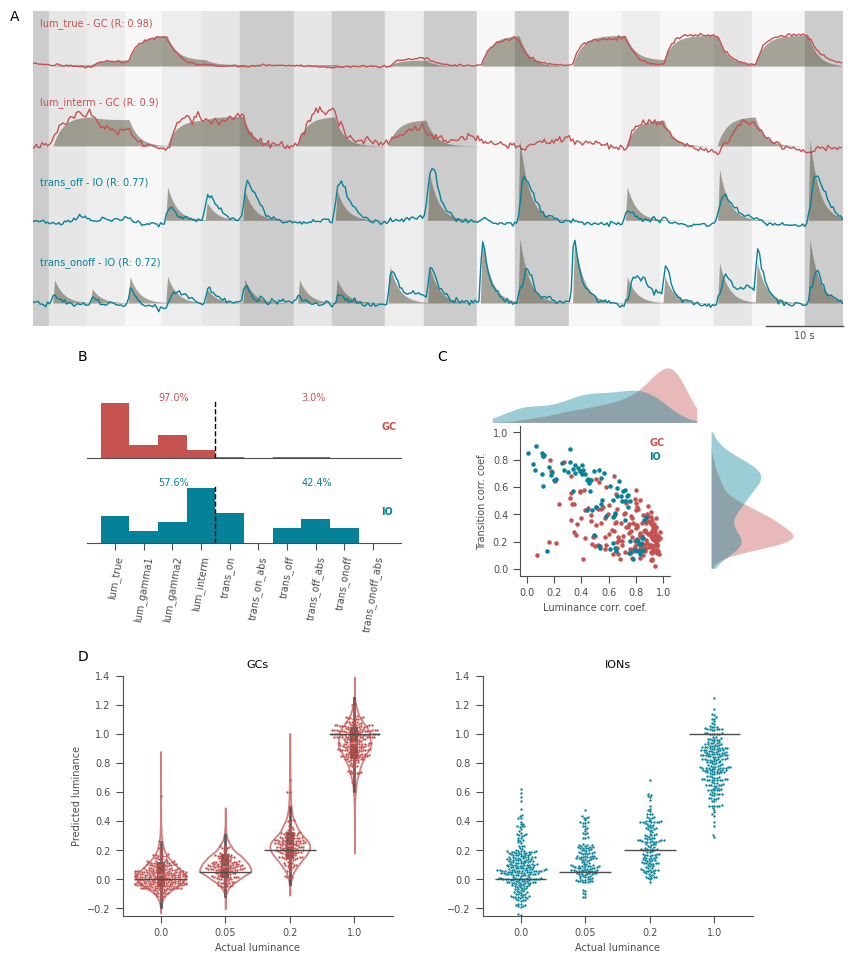

In [31]:
figure3 = plt.figure(figsize=(9,10))

# Regressors traces:
plot_traces_regressors(data_dict, figure=figure3, frame=(0.05, 0.65, .9, 0.35))
figure3.text(.025,.99, 'A')

# Regressors histogram:
reg_hist_figure(data_dict, figure=figure3, frame=(0.06, 0.375, 0.5, 0.25))
figure3.text(.1,.65, 'B')

# Regressors scatterplot:
regr_scatter_plot(data_dict, figure=figure3, frame=(0.45, 0.375, 0.5, 0.3))
figure3.text(.5,.65, 'C')

# Luminance value decoding
plot_luminance_decoding(io_pred_data, gc_pred_data, figure=figure3, frame=(0.05, 0.05, 1, 0.3))
figure3.text(.1,.35, 'D')



In [32]:
if fig_fold is not None:
    figure3.savefig(str(fig_fold / "fig3.pdf"))

# Supplementary figure

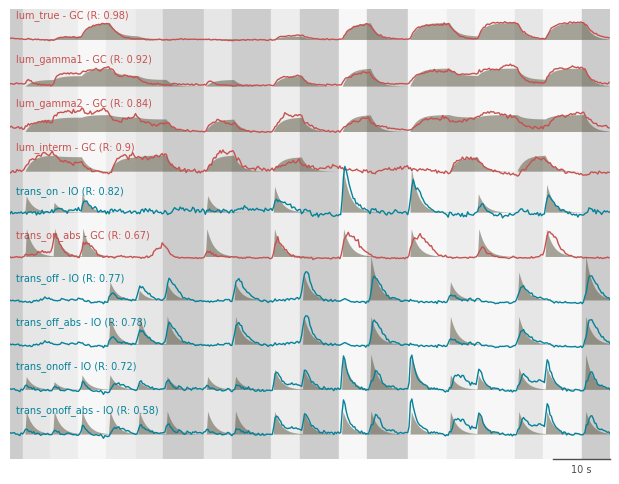

In [33]:
figure3supp = plt.figure(figsize=(6, 5))
plot_traces_regressors(data_dict, figure3supp, frame=(0, 0, 1, 1), regressors_list=reg_keys)

In [34]:
fig_fold = Path(r"C:\Users\otprat\Documents\figures\luminance\manuscript_figures\fig3supp")

if not os.path.isdir(fig_fold):
    os.mkdir(fig_fold)

In [35]:
if fig_fold is not None:
    figure3supp.savefig(fig_fold/ "fig3_supplementary.pdf", format="pdf")